# 환경설정

In [1]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" wikipedia -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import os
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import os
os.environ["HF_TOKEN"] = ""

# 간단한 Chatbot Agent 만들기

In [4]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

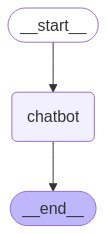

## State 정의
LangGraph에서 LLM 메시지 히스토리를 자동으로 관리하기 위해 사용되는 특별한 필드 정의 방식

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 리스트에 메시지를 append

## Node 정의

In [6]:
# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)
def chatbot(state: State):
    result = llm.invoke(state["messages"])
    return {"messages": result}   # 응답 "messages"에 넣어 반환

## 그래프 정의

In [7]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.set_entry_point("chatbot")      # "chatbot"는 START로 연결
builder.set_finish_point("chatbot")     # "chatbot"는 END로 연결

# builder.add_edge(START, "chatbot")
# builder.add_edge("chatbot", END)

# compile the graph
graph = builder.compile()

## 그래프 시각화

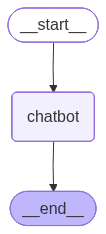

In [8]:
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 그래프 실행

In [9]:
result = graph.invoke({"messages": [HumanMessage("안녕")]})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
result

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='534c70e1-c34b-459f-bb54-05f8855abaee'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 73, 'total_tokens': 144}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b7e5a-fcad-7b80-a2a5-a1758a049a44-0', usage_metadata={'input_tokens': 73, 'output_tokens': 71, 'total_tokens': 144})]}

In [11]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


> 메시지 객체(HumanMessage, AIMessage 등)는 LangChain에서 제공하는 특수 클래스.  
.pretty_print()는 그 메시지를 깔끔하고 보기 좋게 출력하는 함수

* [참조]실행2
    * input을 받아서
    * .stream(...)
        * LangGraph에서 .invoke()는 전체 실행 결과를 한 번에 반환
        * 반면 .stream()은 실행되는 중간 중간 결과를 이벤트처럼 출력할 수 있어! 상태를 점진적으로 업데이트하며 리얼타임 반응처럼 처리 가능
        * 여기서는 state = {"messages": ("user", user_input)}가 전달됨
        * 즉, 사용자 메시지를 상태로 넘김
    * value["messages"][-1].content
        * 각 event는 그래프 실행 도중 생성된 중간 상태들
        * 그 중 "messages" 키의 가장 마지막 메시지(content)를 출력
        * 즉, 에이전트의 최신 응답만 뽑아서 보여줌

In [12]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("잘가!")
        break
    for event in graph.stream({"messages": [HumanMessage(user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"].content)

User: 
Assistant: Hello! How can I help you today?
User: 
Assistant: I’m here to help! Could you let me know what you’d like to discuss or ask about?
User: q
잘가!


# Tool 사용하기

In [13]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

## Custom Tool 만들기

### Tool 준비하기

* langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환 가능

In [14]:
@tool
def calculator_tool(expression: str) -> str:  # type hint : 함수의 출력 type은 str
    '''수식을 입력 받아 계산하는 도구'''
    try:
        result = eval(expression)  # Python 내장 함수 eval()을 사용해서 문자열로 된 식을 계산
        return f"계산 결과: {result}"
    except Exception as e:
        return f"오류 발생: {str(e)}"

@tool
def get_weather(location: str):
    """현재 날씨 정보를 반환합니다."""
    # 입력된 지역이 "서울"인 경우에 해당하는 날씨 정보를 반환합니다.
    if location in ["서울"]:
        return "현재 온도는 20도이며 맑고 화창한 날씨입니다."
    else:
        # "서울"이 아닌 경우, 다른 날씨 정보를 반환합니다.
        return "현재 온도는 10도이며 조금 쌀쌀합니다."

### Tool 등록 및 ToolNode 생성

- tools 리스트: 정의된 tool 함수들을 리스트에 담습니다.
- ToolNode 인스턴스: 등록된 tools들을 관리하고 호출 요청을 처리하기 위해 ToolNode를 생성합니다.

In [15]:
#Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, calculator_tool]
tool_node = ToolNode(tools)

In [16]:
#bind_tools() 함수로 LLM에게 어떤 tool들이 있는지 인지시켜 도구를 활용하도록 만듭니다.
from langchain_openai import ChatOpenAI

llm_with_tools = ChatOpenAI(model="gpt-4.1-mini", temperature=0
                              ).bind_tools(tools)
llm_with_tools.invoke("서울 날씨는 어때?").tool_calls

ModuleNotFoundError: No module named 'langchain_openai'

#### 모델 연결

In [ ]:
# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)

#### LLM에게 도구 사용 규칙 알려주기

In [ ]:
def ask_model(user_input: str):
    prompt = f"""
당신은 다음 두 도구만 사용할 수 있습니다:

1) calculator_tool(expression: str)
2) get_weather(location: str)

절대 OpenAI 스타일의 tool_calls(JSON 형식)를 사용하지 마세요.
예: {{ "tool_calls": ... }}  → 이런 형식 금지.

오직 아래 형식만 사용해야 합니다:

Action: <tool_name>
Action Input: "<string>"

예시:
Action: get_weather
Action Input: "서울"

또는

Action: calculator_tool
Action Input: "2 + 3 * 4"

위의 Action 형식을 지키지 않으면 절대 도구가 실행되지 않습니다.

사용자 질문: {user_input}
"""
    res = llm.invoke(prompt)
    return res.content


#### 모델 출력 파싱 + tool 실행 로직

In [ ]:
import re

def process_output(llm_output: str):
    # Action / Action Input 패턴 탐지
    match = re.search(
        r"Action:\s*(\w+)\s*[\n\r]+Action Input:\s*(.*)",
        llm_output,
        re.IGNORECASE
    )

    if match:
        tool_name = match.group(1)
        tool_input = match.group(2).strip().strip('"')

        if tool_name == "calculator_tool":
            result = calculator_tool.invoke(tool_input)
            return f"[도구 결과] {result}"

        elif tool_name == "get_weather":
            result = get_weather.invoke(tool_input)
            return f"[도구 결과] {result}"

    # 도구 사용 안 하는 일반 대답
    return llm_output


#### 최종 실행 함수

In [ ]:
def run_agent(user_input: str):
    model_output = ask_model(user_input)
    return process_output(model_output)

#### 실행

In [ ]:
print(run_agent("서울 날씨는 어때?"))

In [ ]:
print(run_agent("오늘 점심은 뭐 먹을까?"))

In [ ]:
print(run_agent("1+3*(20-15)"))

### 그래프 만들기
* 그래프 흐름
    - 내장 툴들을 불러오기 (load_tools())
    - 하나의 ToolNode에 묶기
    - LangGraph로 LLM → ToolNode → LLM 구조 실행하기

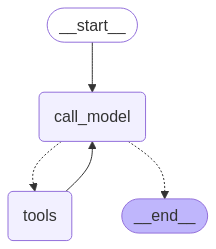

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph

In [ ]:
# huggingface용
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END


* State

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
# huggingface용
class State(TypedDict):
    messages: list  # HumanMessage, AIMessage 모두 포함

* Node 와 분기 함수(conditional edge를 위한 함수)

In [ ]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

In [ ]:
# huggingface용
def call_model(state: State):
    messages = state["messages"]

    # 마지막 메시지만 모델에 전달
    user_msg = messages[-1].content

    response_text = llm.invoke(f"""
사용자가 질문하면 필요한 경우 반드시 아래 형식으로만 도구를 호출하세요.

예)
Action: get_weather
Action Input: "서울"

도구가 필요 없으면 Action 없이 바로 대답.

사용자 입력: {user_msg}
""")

    # 모델의 텍스트 그대로 저장
    return {"messages": messages + [AIMessage(content=response_text.content)]}


In [ ]:
## huggingface용
import re

def tool_node(state: State):
    last = state["messages"][-1].content

    pattern = r"Action:\s*(\w+)\s*[\n\r]+Action Input:\s*\"([^\"]*)\""
    match = re.search(pattern, last)

    if not match:
        # 도구 호출 없음 → 종료로 진행
        return {"messages": state["messages"]}

    tool_name = match.group(1)
    tool_input = match.group(2)

    if tool_name == "get_weather":
        tool_output = get_weather.invoke(tool_input)
    elif tool_name == "calculator_tool":
        tool_output = calculator_tool.invoke(tool_input)
    else:
        tool_output = f"Unknown tool: {tool_name}"

    # 도구 출력 결과를 AIMessage 로 모델에게 넘김
    return {"messages": state["messages"] + [AIMessage(content=f"Tool Result: {tool_output}")]}

In [ ]:
#huggingface용
def should_continue(state: State):
    last = state["messages"][-1].content

    if "Action:" in last:
        return "tools"
    return END

* 그래프 구성

In [ ]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# 연결
builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue,
                            #   {"tools": "tools", END: END}
                              )
builder.add_edge("tools", "call_model")  # 루프 연결

# 컴파일
graph = builder.compile()

In [ ]:
#huggingface용
builder = StateGraph(State)

builder.add_node("model", call_model)
builder.add_node("tools", tool_node)

builder.set_entry_point("model")

builder.add_conditional_edges("model", should_continue, {
    "tools": "tools",
    END: END,
})

builder.add_edge("tools", "model")

graph = builder.compile()



* 그래프 시각화

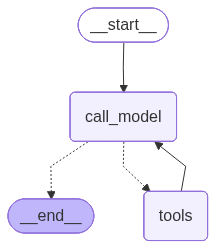

In [ ]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 그래프 사용하기

In [ ]:
final_state = graph.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

NameError: name 'llm_with_tools' is not defined

In [ ]:
#huggingface용
result = graph.invoke({
    "messages": [HumanMessage(content="서울 날씨 알려줘")]
})

print(result["messages"][-1].content)


현재 온도는 20도이며 맑고 화창한 날씨입니다.


# 실습

In [42]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" wikipedia -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.2/457.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 1.2.0 requires langchain-core<2.0.0,>=1.2.0, but you have langchain-core 0.3.81 which is incompatible.
langchain-classic 1.0.1 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.81 which is incompatible.
langchain-classic 1.0.1 requi

## 실습1

* LLM을 하나 생성하시오 (ChatOpenAI)
* 다음 도구 3개를 load_tools()를 사용하여 불러오고, ToolNode로 묶으시오
    * llm-math, wikipedia, serpapi
* GPT에게 도구 목록을 알려주기 위해 .bind_tools(tools)를 사용하시오
* 이를 위해 필요한 준비작업을 수행하시오.
    * serpapi api key를 받아 등록
    * 필요한 라이브러리 설치

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import HumanMessage
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool

### Tool 준비

In [18]:
# 1️⃣ 라이브러리 설치
!pip install langchain langchain_community huggingface_hub google-search-results requests -q

  Preparing metadata (setup.py) ... done


In [19]:
# 1️⃣ 라이브러리 설치
!pip install langchain langgraph huggingface_hub requests -q

In [22]:
!pip install google-search-results -q

In [20]:
# 2️⃣ 필요한 임포트
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from typing import TypedDict, Annotated, Literal

from huggingface_hub import InferenceClient
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
import requests

In [ ]:
from langchain.agents import load_tools
# HuggingFace 모델 endpoint
hf_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")
llm = ChatHuggingFace(llm=hf_ep)
tools = load_tools(["llm-math", "wikipedia", "serpapi"], llm=llm) # 일부 툴이 LLM을 내부적으로 쓸 때 필요한 설정

### ToolNode 생성

In [24]:
tool_node = ToolNode(tools)

In [25]:
# 툴을 쓸 수 있는 LLM
llm_with_tools = llm.bind_tools(tools)  # GPT가 이 툴들을 사용하겠다고 판단할 수 있게 도와주는 설정

### 그래프 만들기
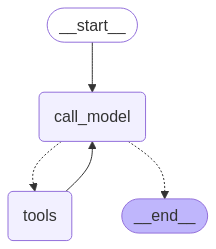

- State

In [26]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [27]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [28]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# 연결
builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")  # 루프 연결

# 컴파일
graph = builder.compile()

* 그래프 시각화

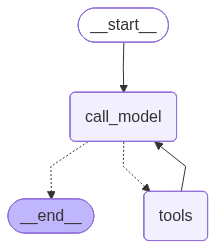

In [29]:
graph

### 그래프 사용하기

In [30]:
result = graph.invoke({
    "messages": [HumanMessage(content="유로 2024 우승팀은?")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

유로 2024 우승팀은?
================================== Ai Message ==================================

유로 2024의 우승팀은 **스페인**입니다.


In [31]:
result = graph.invoke({
    "messages": [HumanMessage(content="deep seek가 주목받은 점은 무엇때문이야?")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

deep seek가 주목받은 점은 무엇때문이야?
================================== Ai Message ==================================

**DeepSeek가 주목받은 핵심 포인트**  
(한국어 & 영어 AI 모델 중심)

| # | 이유 | 구체적 내용 |
|---|------|-------------|
| 1 | **고성능·대용량 모델** | DeepSeek는 13B, 70B 등 다양한 크기의 LLM을 공개했으며, GPT‑4 수준에 근접하거나 그 이상을 보여 주는 벤치마크 성능을 보였습니다. 특히 **한국어 이해·생성**에서 타 모델보다 월등히 높은 점수를 기록했습니다. |
| 2 | **오픈소스 & 커뮤니티 기반** | 대부분의 모델(예: `DeepSeek-Coder`, `DeepSeek-Chat`)을 GitHub에 공개해 누구나 활용·수정이 가능하도록 했습니다. 또한, Hugging Face와 같은 플랫폼에 모델을 업로드해 커뮤니티와의 협업을 장려


## 실습2

* 날씨 기반 의상 추천 에이전트
    * 지역 날씨 정보를 조회한 뒤
    * 해당 날씨에 맞는 옷차림을 추천하는
    * Tool 사용 기반 LangChain Agent
* 요구사항
    * get_weather 툴 정의 : 서울, 부산, 제주 중 입력받은 지역의 날씨 정보 반환
    * recommend_clothing 툴 정의 : 전달받은 날씨 정보(문자열)를 기반으로 옷차림 추천
    * 두 툴을 등록하여 에이전트 생성

* 사용자 질문 : "서울 날씨에 맞는 옷차림 추천해줘"
를 넣었을 때 → 날씨 툴 호출 → 옷 추천 툴 호출 → 답변

### Tool 준비

In [32]:
hf_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")
llm = ChatHuggingFace(llm=hf_ep)

In [33]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """입력한 지역에 대한 고정된 날씨 정보를 반환합니다."""
    weather_db = {
        "서울": "흐림, 9도",
        "부산": "맑음, 18도",
        "제주": "비, 16도"
    }
    return weather_db.get(location, "날씨 정보를 찾을 수 없습니다.")

@tool
def recommend_clothing(weather: str) -> str:
    """날씨 정보를 기반으로 의상을 추천합니다."""
    if "흐림" in weather:
        return "긴팔과 가벼운 외투를 추천합니다."
    elif "맑음" in weather:
        return "반팔과 청바지를 추천합니다."
    elif "비" in weather:
        return "우산과 방수 재킷을 챙기세요."
    else:
        return "기본적인 외출 복장을 추천합니다."


### ToolNode 생성

In [34]:
# 3. 툴과 LLM 연결
tools = [get_weather, recommend_clothing]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

### 그래프 만들기

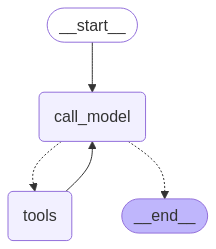

* State

In [35]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [36]:
# 4. 모델 호출 노드
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}

# 5. 조건 분기 함수: 툴 호출 여부 판단
def should_continue(state: State) -> Literal["tools", END]:
    messages = state["messages"]
    last = messages[-1]
    if last.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [37]:
# 6. 그래프 구성
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")

graph = builder.compile()

* 그래프 시각화

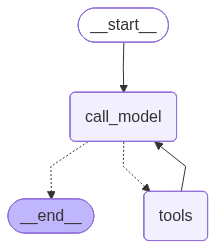

In [38]:
graph

### 그래프 사용하기

In [43]:
from langchain.schema import SystemMessage, HumanMessage

# 메시지 입력
inputs = {
    "messages": [
        SystemMessage(content="당신은 날씨에 따라 옷차림을 추천해주는 비서입니다."),
        HumanMessage(content="서울 날씨에 맞는 옷차림을 추천해줘")
    ]
}

result = graph.invoke(inputs)
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

당신은 날씨에 따라 옷차림을 추천해주는 비서입니다.
================================ Human Message =================================

서울 날씨에 맞는 옷차림을 추천해줘
================================== Ai Message ==================================
Tool Calls:
  get_weather (fc_82c22763-efa0-4a7e-bde7-746224a4ef19)
 Call ID: fc_82c22763-efa0-4a7e-bde7-746224a4ef19
  Args:
    location: 서울
================================= Tool Message =================================
Name: get_weather

흐림, 9도
================================== Ai Message ==================================
Tool Calls:
  recommend_clothing (fc_d571690d-a0a3-4e8a-8ded-6467106b3741)
 Call ID: fc_d571690d-a0a3-4e8a-8ded-6467106b3741
  Args:
    weather: 흐림, 9도
================================= Tool Message =================================
Name: recommend_clothing

긴팔과 가벼운 외투를 추천합니다.
================================== Ai Message ==================================

긴팔 셔츠에 가벼운 트렌치

In [44]:
inputs = {
    "messages": [
        SystemMessage(content="당신은 날씨에 따라 옷차림을 추천해주는 비서입니다."),
        HumanMessage(content="광주 날씨에 맞는 옷차림을 추천해줘")
    ]
}

result = graph.invoke(inputs)
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

당신은 날씨에 따라 옷차림을 추천해주는 비서입니다.
================================ Human Message =================================

광주 날씨에 맞는 옷차림을 추천해줘
================================== Ai Message ==================================
Tool Calls:
  get_weather (fc_21ae67f8-fb34-4824-83b9-36bc79d3c0c2)
 Call ID: fc_21ae67f8-fb34-4824-83b9-36bc79d3c0c2
  Args:
    location: 광주
================================= Tool Message =================================
Name: get_weather

날씨 정보를 찾을 수 없습니다.
================================== Ai Message ==================================

죄송합니다. 현재 광주의 최신 기상 정보를 가져오지 못했습니다.  
일반적으로 광주 지역은 **봄/가을**에는 기온이 10~20 °C 정도, **여름**에는 25~30 °C, **겨울**에는 0~10 °C 정도로 변합니다.  
아래는 그 정도 기온에 맞춘 기본적인 옷차림 가이드입니다. 필요에 따라 조금씩 조절해 주세요!  

| 계절 | 추천 상의 | 하의 | 외투 | 신발 | 기타 |
|------|-----------|------|------|------|------|
| **봄 (10‑20 °C)** | 가벼운 니트/가디건, 반팔 티셔츠 | 청바지, 면바지 | 가벼운 점퍼/트렌치코트 | 스니커즈, 로퍼 | 모자, 가방 |
| **가을 (